In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import copy
import plotly.express as px
import pandas as pd

from utils import (singles, xywh2xyxy, xywhRead, relax, cropLarge)

In [2]:
testDir = 'test'
trainDir = 'train'

singleBBox = singles(trainDir)
np.random.shuffle(singleBBox)

In [3]:
bigImg = cropLarge(cv2.imread('large_images_no_seals/2V3A7581.JPG'), size=600)

for impath in singleBBox:
    txtpath = impath + '.txt'
    impath += '.JPG'
    impath = 'test.JPG'
    txtpath = 'test.txt'
    img = cv2.imread(impath)
    # cv2.imwrite(os.path.join('singleObjects', os.path.basename(impath)), img)
    w, h = img.shape[1], img.shape[0]

    orig_xywh = xywhRead(txtpath)
    relax_xywh = relax(copy.copy(orig_xywh))

    orig_xyxy = xywh2xyxy(orig_xywh)
    relax_xyxy = xywh2xyxy(relax_xywh)
    # converting to pixel coordinates
    orig_xyxy[:, [0, 2]] = orig_xyxy[:, [0, 2]] * w
    orig_xyxy[:, [1, 3]] = orig_xyxy[:, [1, 3]] * h
    orig_xyxy = orig_xyxy.round().astype(int).squeeze()

    relax_xyxy[:, [0, 2]] = relax_xyxy[:, [0, 2]] * w
    relax_xyxy[:, [1, 3]] = relax_xyxy[:, [1, 3]] * h
    relax_xyxy = relax_xyxy.round().astype(int).squeeze()

    orig_xmin, orig_ymin = orig_xyxy[0], orig_xyxy[1]
    orig_xmax, orig_ymax = orig_xyxy[2], orig_xyxy[3]

    relax_xmin, relax_ymin = relax_xyxy[0], relax_xyxy[1]
    relax_xmax, relax_ymax = relax_xyxy[2], relax_xyxy[3]

    smallCrop = img[relax_ymin:relax_ymax, relax_xmin:relax_xmax, :]
    imgMask = np.zeros(img.shape[:-1], dtype=np.uint8)
    imgMask[relax_ymin:relax_ymax, relax_xmin:relax_xmax] = 255
    mask = imgMask[relax_ymin:relax_ymax, relax_xmin:relax_xmax]
    # mask = cv2.resize(mask, (0,0), fx=0.4, fy=0.4)
    # img = cv2.resize(img, (0,0), fx=0.4, fy=0.4)
    for _ in range(4):
        dstImg = next(bigImg).astype(np.uint8)
    out = cv2.seamlessClone(img, dstImg, imgMask, (300, 300), cv2.MIXED_CLONE)
    cv2.imwrite('output/out.jpg', out)
    break
    



Let's try to cluster cropped seal images

In [4]:
# cv2.imwrite('output/out1.jpg', out)
# plt.imshow(smallCrop)

In python opencv __HSV__
 has the following range correspondingly
__[0-179, 0-255, 0-255]__

In [12]:
# HSV = {"img": [], "h": [], "s": [], "v": []}
# for impath in singleBBox:
#     txtpath = impath + '.txt'
#     impath += '.JPG'
#     img = cv2.imread(impath)
#     img = cv2.GaussianBlur(img, (7, 7), 3)
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
#     w, h = img.shape[1], img.shape[0]

#     xywh = xywhRead(txtpath)
#     xyxy = xywh2xyxy(xywh)

#     # converting to pixel coordinates
#     xyxy[:, [0, 2]] = xyxy[:, [0, 2]] * w
#     xyxy[:, [1, 3]] = xyxy[:, [1, 3]] * h
#     xyxy = xyxy.round().astype(int).squeeze()
#     xmin, ymin = xyxy[0], xyxy[1]
#     xmax, ymax = xyxy[2], xyxy[3]

#     hue = hsv[:, :, 0].astype(np.float32)
#     sat = hsv[:, :, 1].astype(np.float32)
#     val = hsv[:, :, 2].astype(np.float32)
#     hue[ymin:ymax, xmin:xmax] = np.nan
#     sat[ymin:ymax, xmin:xmax] = np.nan
#     val[ymin:ymax, xmin:xmax] = np.nan
#     HSV["h"].append(np.nanmean(hue))
#     HSV["s"].append(np.nanmean(sat))
#     HSV["v"].append(np.nanmean(val))
#     HSV["img"].append(impath)
#     # greens.append((np.nanmean(hue), np.nanmean(sat), np.nanmean(val)))
#     # if 55 < np.nanmean(hue) < 80 and np.nanmean(val) > 200 and np.nanmean(sat) < 100:
#     #     greens.append(impath)
# from sklearn.cluster import KMeans
# df = pd.DataFrame(np.array([*HSV.values()]).T)
# hsvArray = df.iloc[:, 1::].astype(np.float32)
# kmeans = KMeans(n_clusters=2, random_state=0).fit(hsvArray)
# clusters = kmeans.labels_
# fig = plt.figure(figsize=(10, 10))

# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(HSV["h"], HSV["s"], HSV["v"], c=clusters)
# plt.show()
# im0 = df.iloc[clusters == 0, :]
# im1 = df.iloc[clusters == 1, :]
# for im in im1[0]:
#     i = cv2.imread(im)
#     cv2.imwrite(os.path.join("1", os.path.basename(im)), i)

# # fig = px.scatter_3d(df["h, s, v, clusters"], x='h', y='s', z='v',
# #               color='clusters')
# # fig.show()

Crop smaller images from annotated large images. \
Recalculate coordinates on small images

In [103]:
# in YOLO annotation, first column stands for class, we don't need it
img = cv2.imread('large_imgs/2V3A7202.JPG')
xywh = np.loadtxt('large_imgs/annotations/2V3A7202.txt')[:, 1::]
xyxy = xywh2xyxy(xywh) 
h, w = img.shape[:-1]

# converting to pixel coordinates
xyxy[:, [0, 2]] = xyxy[:, [0, 2]] * w
xyxy[:, [1, 3]] = xyxy[:, [1, 3]] * h
xyxy = xyxy.round().astype(int).squeeze()
xmin, ymin = xyxy[:,0], xyxy[:,1]
xmax, ymax = xyxy[:,2], xyxy[:,3]


In [104]:
xyxy

array([[5899, 1931, 5918, 1957],
       [5831, 1957, 5842, 1982],
       [5881, 1906, 5910, 1920]])

Loop trough the area defined by the bboxes edge bboxes

In [111]:
leftBBox = xmin.min()  # most left bbox
rightBBox = xmax.max()  # most right bbox
topBBox = ymin.min()  # top one
bottomBBox = ymax.max()  # bottom one

size = 1024  # crop window size
leftBorder = leftBBox - size
rightBorder = rightBBox + size
topBorder = topBBox - size
bottomBorder = bottomBBox + size
if leftBorder < 0:
    leftBorder = 0
elif rightBorder > w:
    rightBorder = w
elif topBorder < 0:
    topBorder = 0
elif bottomBorder > h:
    bottomBorder = h

for xx in range(leftBorder, rightBorder - size, int(size / 2)):
    for yy in range(topBorder, bottomBorder - size, int(size / 2)):

        # check if window contains objects
        leftBool = np.any(xmin > xx)
        rightBool = np.any(xmax < (xx + size))
        topBool = np.any(ymin > yy)
        botBool = np.any(ymax < (yy + size))
        
        # making sure at least one object inside window
        if (leftBool and topBool) and (rightBool and botBool):
            # check if bboxes cross windows edges
            rightCross = np.any(xmax > (xx + size)) and np.any(xmin < (xx + size))
            leftCross = np.any(xmin < xx) and np.any(xmax > xx)
            topCross = np.any(ymin < yy) and np.any(ymax > yy)
            bottomCross = np.any(ymax > (yy + size)) and np.any(ymin < (yy + size))
            if rightCross:
                print('rightCross')
            elif leftCross:
                print('leftCross')
            elif topCross:
                print('topCross')
            elif bottomCross:
                print('bottomCross')
                cv2.imwrite('bottomCross.jpg', img[yy:yy+size, xx:xx+size, :])
            # break

        # plt.figure(figsize=(20,20))
        # plt.imshow(img[yy:yy+size, xx:xx+size, ::-1])
        # plt.show()
        cv2.rectangle(img, (xx, yy), (xx+size, yy+size), (np.random.randint(0, 255), 0, 0), 5)
        print(xx, yy)

# plt.figure(figsize=(20,20))
# plt.imshow(img)

4807 882
4807 1394
4807 1906
5319 882
5319 1394
5319 1906
5831 882
5831 1394
5831 1906


True

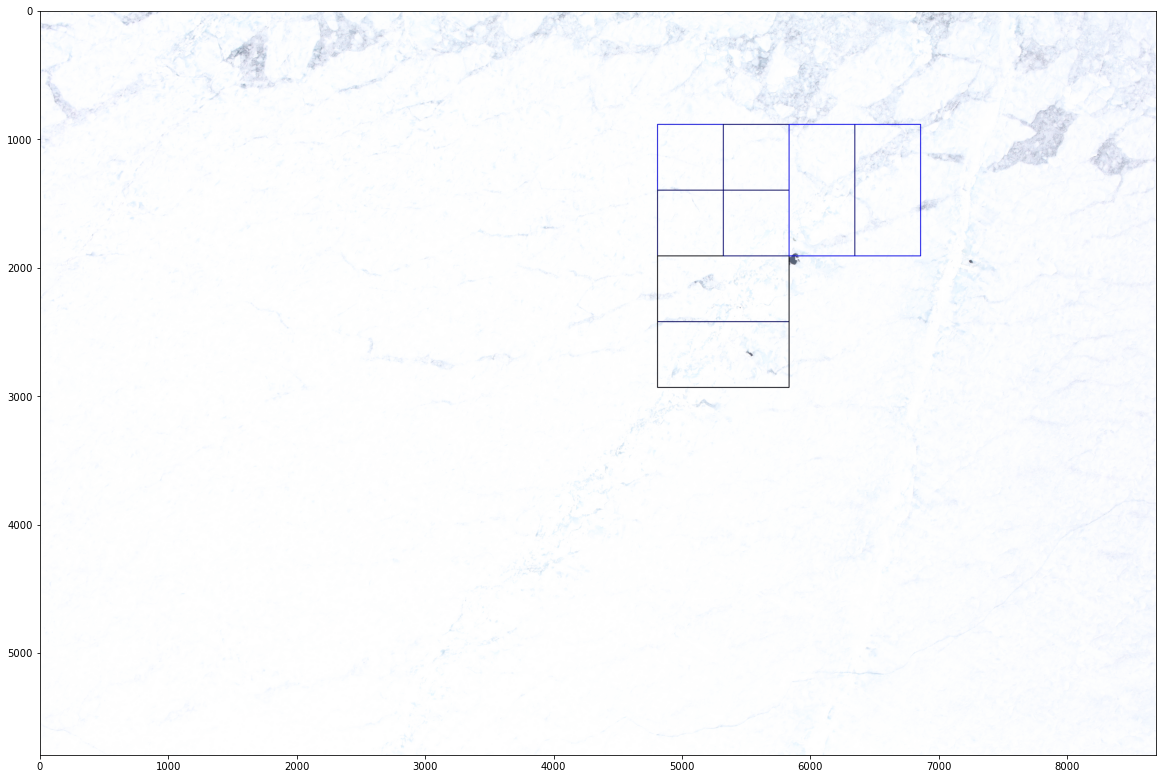

In [108]:
# cv2.rectangle(img, (leftBorder, topBorder), (rightBorder, bottomBorder), (0, 255, 0), 5)
plt.figure(figsize=(20,20))
plt.imshow(img[...,::-1])
cv2.imwrite('blabla.jpg', img)

In [14]:
def cropTrue(xyxy, xywh, hImg, wImg, size=1024):
    '''
    crops annotated images and recalculates coordinates
    of the objects appearing in the cropped images

    :param img: original image
    :param xyxy: obj coordinates on the original image
    :param size: cropping size
    '''

    xyxy[:, [0, 2]] = xyxy[:, [0, 2]] * wImg
    xyxy[:, [1, 3]] = xyxy[:, [1, 3]] * hImg
    wbbox = xywh[:, 2] * wImg
    hbbox = xywh[:, 3] * hImg
    xyxy = xyxy.round().astype(int).squeeze()
    xmin, ymin = xyxy[:,0], xyxy[:,1]
    xmax, ymax = xyxy[:,2], xyxy[:,3]

    for i in range(int(size/2), int(wImg-size/2), int(size/8)):
        for j in range(int(size/2), int(hImg-size/2), int(size/8)):
            winX = i
            winY = j
            # check if window contains an object
            leftBool = xmin > (winX - int(size/2))
            rightBool = xmax < (winX + int(size/2))
            topBool = ymin > (winY - int(size/2))
            botBool = ymax < (winY + int(size/2))

            if np.any(leftBool) and np.any(rightBool) and np.any(topBool) and np.any(botBool):
                
                newXmin = xmin[leftBool] - (winX - size / 2)
                newXmax = newXmin + wbbox
                newYmin = ymin[topBool] - (winY - size / 2)
                newYmax = newYmin + hbbox

                yield ((newXmin, newYmin, newXmax, newYmax), (winX, winY))
            else:
                continue


In [15]:
size = 1024

xywh = np.loadtxt('large_imgs/annotations/1V1A8820.txt')[:, 1::]
xyxy = xywh2xyxy(xywh) 
h, w = img.shape[:-1]

xyxy[:, [0, 2]] = xyxy[:, [0, 2]] * w
xyxy[:, [1, 3]] = xyxy[:, [1, 3]] * h
wbbox = xywh[:, 2] * w
hbbox = xywh[:, 3] * h
xyxy = xyxy.round().astype(int).squeeze()
xmin, ymin = xyxy[:,0], xyxy[:,1]
xmax, ymax = xyxy[:,2], xyxy[:,3]

for i in range(int(size/2), int(w-size/2), int(size/8)):
    for j in range(int(size/2), int(h-size/2), int(size/8)):
        winX = i
        winY = j
        # check if window contains an object
        leftBool = xmin > (winX - int(size/2))
        rightBool = xmax < (winX + int(size/2))
        topBool = ymin > (winY - int(size/2))
        botBool = ymax < (winY + int(size/2))

        if np.any(leftBool) and np.any(rightBool) and np.any(topBool) and np.any(botBool):
            print('there')
            newXmin = xmin[leftBool] - (winX - size / 2)
            newXmax = newXmin + wbbox
            newYmin = ymin[topBool] - (winY - size / 2)
            newYmax = newYmin + hbbox
            break

there
there
there
there
there
there
there
there
